# Basic Imports

In [66]:
import numpy as np
import pandas as pd
import keras
from gensim.models import KeyedVectors
from keras.layers import Flatten, Embedding
from keras.layers import MaxPooling1D, Conv1D, GlobalMaxPool1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from nltk.corpus import stopwords
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Dropout, Flatten
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

# Reading the data
## Data contains customer review (short sentences) and ratings (1,2,3,4 or 5)

In [67]:
import os
os.chdir("C:/Users/DHRUVIL/OneDrive/Stratsntools/Python Directory")

In [68]:
df=pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [69]:
df['Review Text']=df['Review Text'].astype('str')

# Pre-Processing
## converting words like 'wouldn't' to 'would not'

In [70]:
from nltk.tokenize import sent_tokenize,word_tokenize

replacement_patterns = [
(r'won\'t', 'will not'),
(r'can\'t', 'cannot'),
(r'i\'m', 'i am'),
(r'ain\'t', 'is not'),
(r'(\w+)\'ll', '\g<1> will'),
(r'(\w+)n\'t', '\g<1> not'),
(r'(\w+)\'ve', '\g<1> have'),
(r'(\w+)\'s', '\g<1> is'),
(r'(\w+)\'re', '\g<1> are'),
(r'(\w+)\'d', '\g<1> would')
]

class RegexpReplacer(object):
    def __init__(self,patterns=replacement_patterns):
        self.patterns=[(re.compile(regex),repl) for (regex,repl) in patterns]
    def replace(self,text):
        s=text
        for (pattern,repl) in self.patterns:
            (s,count)=re.subn(pattern,repl,s)
        return s


# In[7]:

import re
replacer= RegexpReplacer()
df['Review Text'] = df['Review Text'].apply(lambda x: replacer.replace(x))

## Tokenizing, Stopwords removal, Lower casing

In [71]:
from nltk.tokenize import word_tokenize 
df['tokenizedx'] = df['Review Text'].apply(lambda x: word_tokenize(str(x)))


from nltk.corpus import stopwords
stop=stopwords.words('english')
df['tokenizedx']=df['tokenizedx'].apply(lambda x: [y for y in x if y not in stop])


df['tokenizedx'] = df['tokenizedx'].apply(lambda x: [y.lower() for y in x])

## Punctuation removal and word segmentation

In [72]:
import string
import re
x=re.compile('[%s]' % re.escape(string.punctuation))
def remove_punct(tokens):
    new=[]
    for t in tokens:
        mt=x.sub(u'',t)
        if not mt==u'':
            new.append(mt)
    return new


from itertools import chain
df['tokenizedx'] = df['tokenizedx'].apply(lambda x: [remove_punct(x)])
df['tokenizedx'] = df['tokenizedx'].apply(lambda x: list(chain.from_iterable(x)))

from wordsegment import load, segment
load()
df['tokenizedx'] = df['tokenizedx'].apply(lambda x: [segment(y) for y in x])
from itertools import chain
df['tokenizedx'] = df['tokenizedx'].apply(lambda x: list(chain.from_iterable(x)))

    

# Exploring the Ratings label.
## As we see a clear imbalance, we binarize the output as 0 (Ratings<=3) and 1 (Ratings>=4)

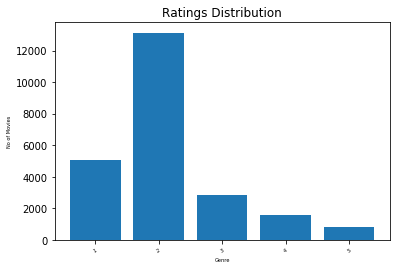

In [73]:
from collections import Counter

count=Counter(df.Rating)
count
import matplotlib.pyplot as plt

def plot_bar_x():
    # this is for plotting purpose
    index = range(1,6)
    plt.bar(index, list(count.values()))
    plt.xlabel('Genre', fontsize=5)
    plt.ylabel('No of Movies', fontsize=5)
    plt.xticks(index, index, fontsize=5, rotation=30)
    plt.title('Ratings Distribution')
    plt.show()

plot_bar_x()

In [74]:
for i in df.index.values.tolist():
    if df.loc[i,'Rating']<=3:
        df.loc[i,'Rating']='0'
    else:
        df.loc[i,'Rating']='1'

# Converting text to vectors
## We define MAX_NB_WORDS as the maximum number of words we want to keep. The words are selected on the basis of their occurences in the dataset
## Max sequence length is the maximum number of tokens we want to see in each review
## Embedding dimension is the dimension of the word vectors we want to build
## We use the tokenizer to tokenize the sentences (Reviews) and then convert the tokens to a sequence of numbers. The numbers denote the identity assigned to each word (tokens)
## To ensure uniform length of the sequences, we pad them

In [75]:
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 100

tokenizer=Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['Review Text'])
seq=tokenizer.texts_to_sequences(df['Review Text'])
seq=pad_sequences(seq,maxlen=30)


In [76]:
y=np.array(df['Rating'])
y=np_utils.to_categorical(y)

In [77]:
VALIDATION_SPLIT = 0.4
indices = np.arange(df.shape[0]) # get sequence of row index
np.random.shuffle(indices) # shuffle the row indexes
data = seq[indices] # shuffle data/product-titles/x-axis
category = y[indices] # shuffle labels/category/y-axis
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = category[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = category[-nb_validation_samples:]

# Training a Word2Vec model

In [78]:
import gensim
sentences = []
for i in df.index.tolist():
    sentences.append(df.loc[i,'tokenizedx'])

model=gensim.models.Word2Vec(sentences,min_count=2,size=100)

# Creating Embeddings
## We create a numpy zeros array of dimension (words,embedding dimensions) and store vectors from Word2Vec model in rows corresponding to word indices
## Word2Vec embeddings are used to initialize the weights of the embedding layer in the subsequent code
## +1 in nb_words because we don't have 0 in word_index

In [79]:
from keras.layers import Embedding
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in model.wv.vocab.keys():
        embedding_matrix[i] = model[word]

C:\Users\DHRUVIL\Anaconda_3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# Embedding Layer (Does not exactly captures semantics like Word2Vec. Majorly serves the classification purpose)
https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

In [80]:
embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
trainable=False)

# Model
## This isn't tuned. Like mentioned, this is just a framework.

In [81]:

CNN_model = Sequential()
CNN_model.add(embedding_layer)
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(150, 4, padding='valid',activation='relu',strides=2))
CNN_model.add(Conv1D(250, 3, padding='valid',activation='relu',strides=2))
CNN_model.add(Conv1D(400, 2, padding='valid',activation='relu',strides=2))
CNN_model.add(Flatten())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(150,activation='sigmoid'))
CNN_model.add(Dense(150,activation='sigmoid'))
CNN_model.add(Dense(150,activation='sigmoid'))
CNN_model.add(Dense(150,activation='sigmoid'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Dense(2,activation='sigmoid'))

In [82]:
CNN_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])

# Fitting the model

In [84]:
CNN_model.fit(x_train, y_train, epochs=15, batch_size=300)

Epoch 1/15
14092/14092 [==============================] - 14s 967us/step - loss: 0.4381 - acc: 0.7812
Epoch 2/15
14092/14092 [==============================] - 15s 1ms/step - loss: 0.4329 - acc: 0.7904
Epoch 3/15
14092/14092 [==============================] - 14s 997us/step - loss: 0.4330 - acc: 0.7903
Epoch 4/15
14092/14092 [==============================] - 14s 1ms/step - loss: 0.4229 - acc: 0.7978
Epoch 5/15
14092/14092 [==============================] - 15s 1ms/step - loss: 0.4245 - acc: 0.7943
Epoch 6/15
14092/14092 [==============================] - 14s 974us/step - loss: 0.4113 - acc: 0.8065
Epoch 7/15
14092/14092 [==============================] - 14s 965us/step - loss: 0.4105 - acc: 0.8059
Epoch 8/15
14092/14092 [==============================] - 14s 976us/step - loss: 0.4036 - acc: 0.8133
Epoch 9/15
14092/14092 [==============================] - 14s 972us/step - loss: 0.3982 - acc: 0.8117
Epoch 10/15
14092/14092 [==============================] - 13s 923us/step - loss: 0.3921

In [85]:
pred=CNN_model.evaluate(x_val,y_val)

9394/9394 [==============================] - 4s 398us/step


## Accuracy

In [ ]:
pred[1]